In [23]:
import micrograph as mg
import dncnn
import util

import sigpy as sp
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot as plt

np.random.seed(77)

In [24]:
import matplotlib
font = {'family' : 'DejaVu Sans',
        'size'   : 18}

matplotlib.rc('font', **font)

# Measurement Quality and Optimal Regularization Parameter

In [25]:
imPath = 'data/sponge/val/0.jpg'
dynamicRange = [2, 8]
etaGt = util.readImageToEta(imPath, minEta=dynamicRange[0], maxEta=dynamicRange[1])

1.2027192011794055 0.8462179338871634


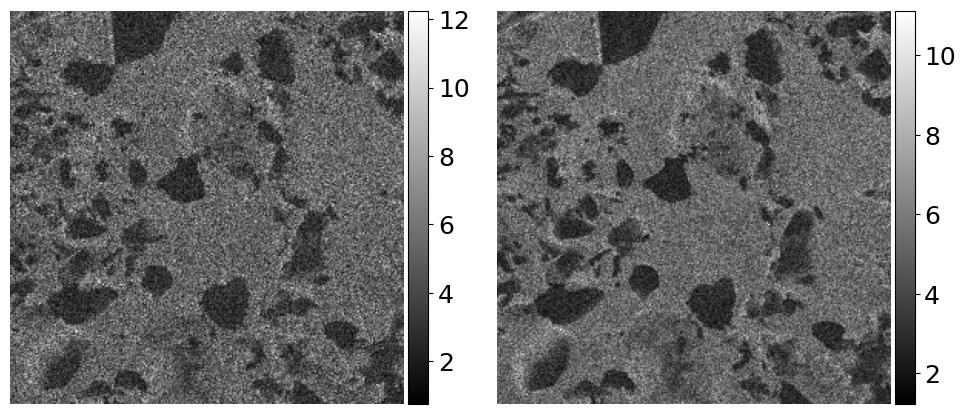

In [26]:
# Measurement, high noise
lamb1 = 20
n1 = 200
yTr1 = mg.poiPoiTrSampling(etaGt, lamb1, n1, retM = False)
etaInit1 = yTr1.sum(axis=0) / lamb1

# Measurement, low noise
lamb2 = 40
n2 = 400
yTr2 = mg.poiPoiTrSampling(etaGt, lamb2, n2, retM = False)
etaInit2 = yTr2.sum(axis=0) / lamb2

print(util.computeRMSE(etaInit1, etaGt), util.computeRMSE(etaInit2, etaGt))
util.imshow([etaInit1, etaInit2])

In [27]:
def computeQMLoss(eta, yTr):
    L = np.sum(yTr > 0, axis=0).astype(float)
    yConv = yTr.sum(axis=0)
    return np.mean(L * eta - yConv * np.log(eta))

def computeLQMLoss(eta, yTr):
    L = np.sum(yTr > 0, axis=0).astype(float)
    yConv = yTr.sum(axis=0)
    return np.mean(L * (eta / (1 - np.exp(-eta))) + yConv * np.log(1 - np.exp(-eta)) - yConv * np.log(eta))

In [28]:
# Loss scaling with lambda and n (already normalized by the number of pixels)
qmLoss1 = computeQMLoss(etaGt, yTr1)
qmLoss2 = computeQMLoss(etaGt, yTr2)
ratio = qmLoss2 / qmLoss1
print('lambda = {}, QM loss = {}'.format(lamb1, qmLoss1))
print('lambda = {}, QM loss = {}'.format(lamb2, qmLoss2))
print('Ratio = {}'.format(qmLoss2 / qmLoss1))

lqmLoss1 = computeLQMLoss(etaGt, yTr1)
lqmLoss2 = computeLQMLoss(etaGt, yTr2)
ratio = lqmLoss2 / lqmLoss1
print('lambda = {}, LQM loss = {}'.format(lamb1, lqmLoss1))
print('lambda = {}, LQM loss = {}'.format(lamb2, lqmLoss2))
print('Ratio = {}'.format(lqmLoss2 / lqmLoss1))

lambda = 20, QM loss = -61.94010340707804
lambda = 40, QM loss = -123.85169604593142
Ratio = 1.99953970421978
lambda = 20, LQM loss = -62.00691755029192
lambda = 40, LQM loss = -123.98652275999875
Ratio = 1.9995595275226683


We observe that the loss wrt ground truth scales approximately linearly with $n$. To make results for different $n$ and $\lambda$ comparable, we will use normalized loss for PnP-ADMM.

$$
f_{QM} = \frac{1}{n} \sum_{k = 1}^d (L_k \eta_k - y^C_k \log \eta_k)
$$
$$
f_{LQM} = \frac{1}{n} \sum_{k = 1}^d \left(L_k \frac{\eta_k}{1 - e^{-\eta_k}} + y^C_k \log (1 - e^{-\eta_k}) - y^C_k \log \eta_k \right)
$$

The corresponding proximal operators become
$$
\text{prox}_{f_{QM}}(v - u) = -\frac{1}{2} \left(\frac{L}{\rho n} - v + u\right) + \frac{1}{2} \sqrt{\left(\frac{L}{\rho n} - v + u\right)^2 + \frac{4y^C}{\rho n}}
$$

$$
\text{prox}_{f_{LQM}}(v - u) = -\frac{1}{2} \left(\frac{L}{\rho n (1 - e^{-\eta^{\text{prev}}})} - v + u\right) + \frac{1}{2} \sqrt{\left(\frac{L}{\rho n (1 - e^{-\eta^{\text{prev}}})} - v + u\right)^2 + \frac{4y^C}{\rho n}}
$$

In [29]:
class QMNormalizedFidProx(sp.prox.Prox):
    def __init__(self, y):
        super().__init__(y[0].shape)
        self.yConv = np.sum(y, axis=0)
        self.L = np.sum(y > 0, axis=0).astype(float)
        self.n = y.shape[0]
        self.reqPrevEta = False

    def _prox(self, rho, input):
        diff = self.L / (rho * self.n) - input
        return 0.5 * (-diff + np.sqrt(diff ** 2 + 4 * self.yConv / (rho * self.n)))

class LQMNormalizedApproxFidProx:
    def __init__(self, y):
        self.yConv = np.sum(y, axis=0)
        self.L = np.sum(y > 0, axis=0).astype(float)
        self.n = y.shape[0]
        self.reqPrevEta = True

    def __call__(self, rho, input, etaPrev):
        diff = self.L / (rho * self.n * (1 - np.exp(-etaPrev))) - input
        return 0.5 * (-diff + np.sqrt(diff ** 2 + 4 * self.yConv / (rho * self.n)))

Let's find the optimal $\beta$ at different $\lambda$ values using these new updates.

## TV denoiser

In [30]:
# Fixed parameters
rho = 0.005
maxIter = 100
tol = 5e-4
betaChoices = np.linspace(0.01, 0.06, 10)
sigmaChoices = np.sqrt(betaChoices / rho)

### QM

In [26]:
# QM-TV ADMM for lambda = 20
hist1 = []
for sigma, beta in zip(sigmaChoices, betaChoices):
    fidProx = QMNormalizedFidProx(yTr1)
    priorProx = mg.TVPriorProx(sigma)
    app = mg.ADMMApp(fidProx, priorProx, rho, etaInit1, maxIter,
                    tol=tol, xGt=etaGt)
    etaRecon = app.run()
    mse, rmse, psnr, snr, ssim = util.computeErrorMetrics(etaRecon, etaGt, dynamicRange[1] - dynamicRange[0])
    hist1 += [{'beta': beta, 'sigma': sigma, 'rmse': rmse, 'ssim': ssim}]
hist1 = pd.DataFrame(hist1)

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

In [27]:
# QM-TV ADMM for lambda = 40
hist2 = []
for sigma, beta in zip(sigmaChoices, betaChoices):
    fidProx = QMNormalizedFidProx(yTr2)
    priorProx = mg.TVPriorProx(sigma)
    app = mg.ADMMApp(fidProx, priorProx, rho, etaInit2, maxIter,
                    tol=tol, xGt=etaGt)
    etaRecon = app.run()
    mse, rmse, psnr, snr, ssim = util.computeErrorMetrics(etaRecon, etaGt, dynamicRange[1] - dynamicRange[0])
    hist2 += [{'beta': beta, 'sigma': sigma, 'rmse': rmse, 'ssim': ssim}]
hist2 = pd.DataFrame(hist2)

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 20, best beta = 0.048888888888888885
lambda = 40, best beta = 0.02111111111111111


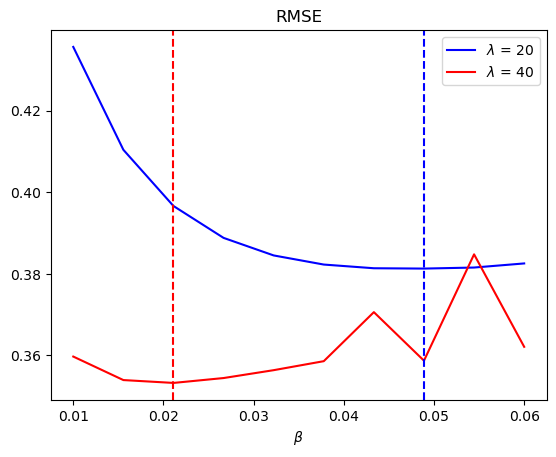

In [28]:
beta1 = hist1.loc[hist1['rmse'] == hist1['rmse'].min()]['beta'].iloc[0]
beta2 = hist2.loc[hist2['rmse'] == hist2['rmse'].min()]['beta'].iloc[0]
print('lambda = {}, best beta = {}'.format(lamb1, beta1))
print('lambda = {}, best beta = {}'.format(lamb2, beta2))

plt.plot(betaChoices, hist1.loc[:, 'rmse'], label=r'$\lambda$ = {}'.format(lamb1), c='b')
plt.plot(betaChoices, hist2.loc[:, 'rmse'], label=r'$\lambda$ = {}'.format(lamb2), c='r')
plt.axvline(x=beta1, ls='--', c='b')
plt.axvline(x=beta2, ls='--', c='r')
plt.xlabel(r'$\beta$')
plt.title('RMSE')
plt.legend()
plt.show()

lambda = 20, best beta = 0.05444444444444444
lambda = 40, best beta = 0.026666666666666665


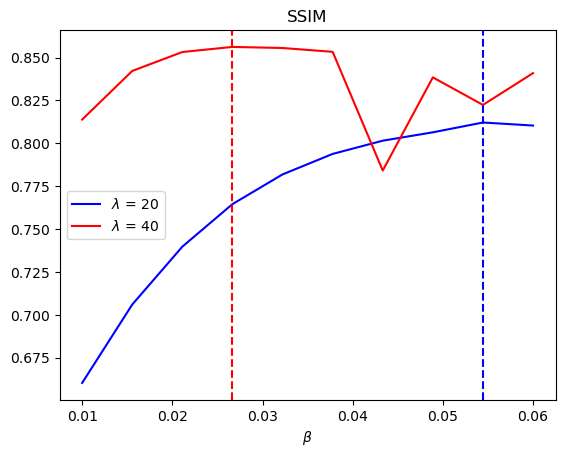

In [29]:
beta1 = hist1.loc[hist1['ssim'] == hist1['ssim'].max()]['beta'].iloc[0]
beta2 = hist2.loc[hist2['ssim'] == hist2['ssim'].max()]['beta'].iloc[0]
print('lambda = {}, best beta = {}'.format(lamb1, beta1))
print('lambda = {}, best beta = {}'.format(lamb2, beta2))

plt.plot(betaChoices, hist1.loc[:, 'ssim'], label=r'$\lambda$ = {}'.format(lamb1), c='b')
plt.plot(betaChoices, hist2.loc[:, 'ssim'], label=r'$\lambda$ = {}'.format(lamb2), c='r')
plt.axvline(x=beta1, ls='--', c='b')
plt.axvline(x=beta2, ls='--', c='r')
plt.xlabel(r'$\beta$')
plt.title('SSIM')
plt.legend()
plt.show()

### LQM

In [31]:
# LQM-TV ADMM for lambda = 20
hist1 = []
for sigma, beta in zip(sigmaChoices, betaChoices):
    fidProx = LQMNormalizedApproxFidProx(yTr1)
    priorProx = mg.TVPriorProx(sigma)
    app = mg.ADMMApp(fidProx, priorProx, rho, etaInit1, maxIter,
                    tol=tol, xGt=etaGt)
    etaRecon = app.run()
    mse, rmse, psnr, snr, ssim = util.computeErrorMetrics(etaRecon, etaGt, dynamicRange[1] - dynamicRange[0])
    hist1 += [{'beta': beta, 'sigma': sigma, 'rmse': rmse, 'ssim': ssim}]
hist1 = pd.DataFrame(hist1)

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
# LQM-TV ADMM for lambda = 40
hist2 = []
for sigma, beta in zip(sigmaChoices, betaChoices):
    fidProx = LQMNormalizedApproxFidProx(yTr2)
    priorProx = mg.TVPriorProx(sigma)
    app = mg.ADMMApp(fidProx, priorProx, rho, etaInit2, maxIter,
                    tol=tol, xGt=etaGt)
    etaRecon = app.run()
    mse, rmse, psnr, snr, ssim = util.computeErrorMetrics(etaRecon, etaGt, dynamicRange[1] - dynamicRange[0])
    hist2 += [{'beta': beta, 'sigma': sigma, 'rmse': rmse, 'ssim': ssim}]
hist2 = pd.DataFrame(hist2)

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 20, best beta = 0.048888888888888885
lambda = 40, best beta = 0.02111111111111111


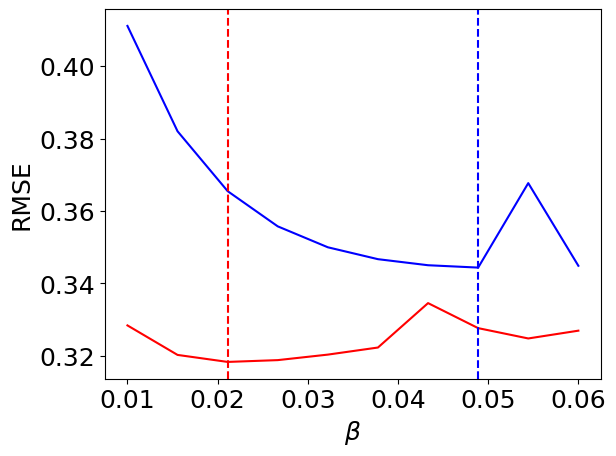

In [34]:
beta1 = hist1.loc[hist1['rmse'] == hist1['rmse'].min()]['beta'].iloc[0]
beta2 = hist2.loc[hist2['rmse'] == hist2['rmse'].min()]['beta'].iloc[0]
print('lambda = {}, best beta = {}'.format(lamb1, beta1))
print('lambda = {}, best beta = {}'.format(lamb2, beta2))

plt.plot(betaChoices, hist1.loc[:, 'rmse'], label=r'$\lambda$ = {}'.format(lamb1), c='b')
plt.plot(betaChoices, hist2.loc[:, 'rmse'], label=r'$\lambda$ = {}'.format(lamb2), c='r')
plt.axvline(x=beta1, ls='--', c='b')
plt.axvline(x=beta2, ls='--', c='r')
plt.xlabel(r'$\beta$')
plt.ylabel('RMSE')
plt.legend()
plt.show()
# plt.savefig('lqmTvLambda.png', bbox_inches='tight')

lambda = 20, best beta = 0.06
lambda = 40, best beta = 0.03222222222222222


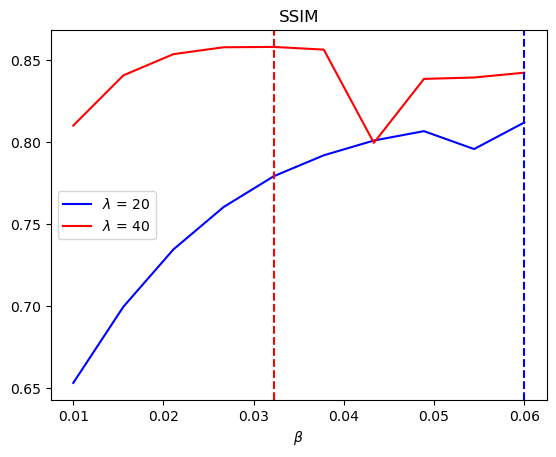

In [33]:
beta1 = hist1.loc[hist1['ssim'] == hist1['ssim'].max()]['beta'].iloc[0]
beta2 = hist2.loc[hist2['ssim'] == hist2['ssim'].max()]['beta'].iloc[0]
print('lambda = {}, best beta = {}'.format(lamb1, beta1))
print('lambda = {}, best beta = {}'.format(lamb2, beta2))

plt.plot(betaChoices, hist1.loc[:, 'ssim'], label=r'$\lambda$ = {}'.format(lamb1), c='b')
plt.plot(betaChoices, hist2.loc[:, 'ssim'], label=r'$\lambda$ = {}'.format(lamb2), c='r')
plt.axvline(x=beta1, ls='--', c='b')
plt.axvline(x=beta2, ls='--', c='r')
plt.xlabel(r'$\beta$')
plt.title('SSIM')
plt.legend()
plt.show()

## DnCNN denoiser

According to Xu et al. (2020), if we assume that the denoiser is the proximal operator of a 1-homogeneous function $g$, then the $\mu$-scaled denoiser is the proximal operator of $\mu^{-1} g$. 

Therefore, roughly, if we assume that the unscaled denoiser has an associated strength $\beta$, the $\mu$-scaled version has the strength $\beta / \mu$.

In [13]:
# St up model
denRange = [0, 1]
device = torch.device('cpu')
model = dncnn.DnCNN(17)
dncnn.loadCheckpoint('model/std25.ckpt', model)

In [14]:
# Fixed parameters
rho = 0.005
maxIter = 100
tol = 5e-4
sigmaInit = (25 / 255) * (dynamicRange[1] - dynamicRange[0])
betaInit = rho * (sigmaInit ** 2)
muChoices = np.array([0.2, 0.3, 0.4, 0.5, 0.6])
betaChoices = betaInit / muChoices

### QM

In [36]:
# QM-DnCNN ADMM for lambda = 20
hist1 = []
for mu, beta in zip(muChoices, betaChoices):
    fidProx = QMNormalizedFidProx(yTr1)
    priorProx = mg.DnCNNPriorProx(model, device, mu, dynamicRange, denRange)
    app = mg.ADMMApp(fidProx, priorProx, rho, etaInit1, maxIter,
                    tol=tol, xGt=etaGt)
    etaRecon = app.run()
    mse, rmse, psnr, snr, ssim = util.computeErrorMetrics(etaRecon, etaGt, dynamicRange[1] - dynamicRange[0])
    hist1 += [{'beta': beta, 'mu': mu, 'rmse': rmse, 'ssim': ssim}]
hist1 = pd.DataFrame(hist1)

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
# QM-DnCNN ADMM for lambda = 40
hist2 = []
for mu, beta in zip(muChoices, betaChoices):
    fidProx = QMNormalizedFidProx(yTr2)
    priorProx = mg.DnCNNPriorProx(model, device, mu, dynamicRange, denRange)
    app = mg.ADMMApp(fidProx, priorProx, rho, etaInit2, maxIter,
                    tol=tol, xGt=etaGt)
    etaRecon = app.run()
    mse, rmse, psnr, snr, ssim = util.computeErrorMetrics(etaRecon, etaGt, dynamicRange[1] - dynamicRange[0])
    hist2 += [{'beta': beta, 'mu': mu, 'rmse': rmse, 'ssim': ssim}]
hist2 = pd.DataFrame(hist2)

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 20, best beta = 0.005767012687427913
lambda = 40, best beta = 0.003460207612456748


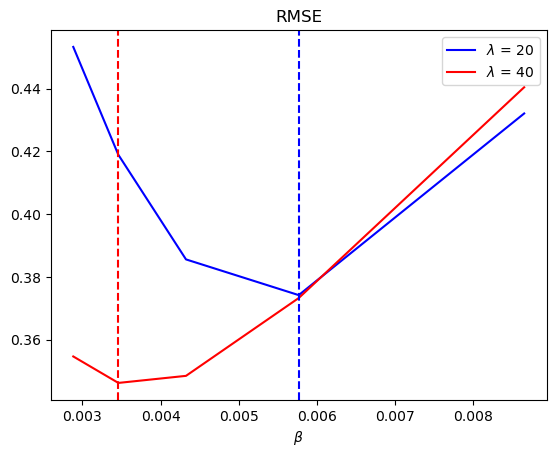

In [38]:
beta1 = hist1.loc[hist1['rmse'] == hist1['rmse'].min()]['beta'].iloc[0]
beta2 = hist2.loc[hist2['rmse'] == hist2['rmse'].min()]['beta'].iloc[0]
print('lambda = {}, best beta = {}'.format(lamb1, beta1))
print('lambda = {}, best beta = {}'.format(lamb2, beta2))

plt.plot(hist1.loc[:, 'beta'], hist1.loc[:, 'rmse'], label=r'$\lambda$ = {}'.format(lamb1), c='b')
plt.plot(hist2.loc[:, 'beta'], hist2.loc[:, 'rmse'], label=r'$\lambda$ = {}'.format(lamb2), c='r')
plt.axvline(x=beta1, ls='--', c='b')
plt.axvline(x=beta2, ls='--', c='r')
plt.xlabel(r'$\beta$')
plt.title('RMSE')
plt.legend()
plt.show()

lambda = 20, best mu = 0.3
lambda = 40, best mu = 0.5


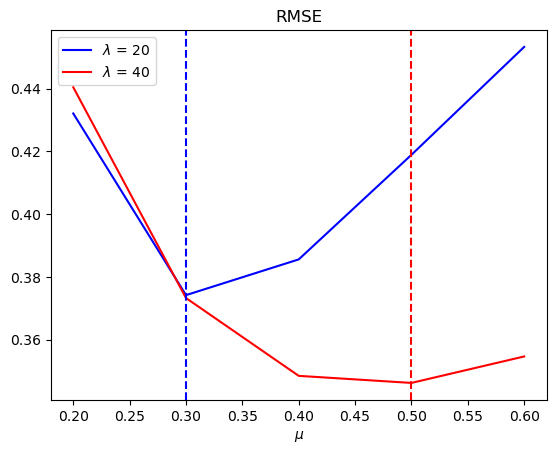

In [39]:
mu1 = hist1.loc[hist1['rmse'] == hist1['rmse'].min()]['mu'].iloc[0]
mu2 = hist2.loc[hist2['rmse'] == hist2['rmse'].min()]['mu'].iloc[0]
print('lambda = {}, best mu = {}'.format(lamb1, mu1))
print('lambda = {}, best mu = {}'.format(lamb2, mu2))

plt.plot(hist1.loc[:, 'mu'], hist1.loc[:, 'rmse'], label=r'$\lambda$ = {}'.format(lamb1), c='b')
plt.plot(hist2.loc[:, 'mu'], hist2.loc[:, 'rmse'], label=r'$\lambda$ = {}'.format(lamb2), c='r')
plt.axvline(x=mu1, ls='--', c='b')
plt.axvline(x=mu2, ls='--', c='r')
plt.xlabel(r'$\mu$')
plt.title('RMSE')
plt.legend()
plt.show()

### LQM

In [15]:
# LQM-DnCNN ADMM for lambda = 20
hist1 = []
for mu, beta in zip(muChoices, betaChoices):
    fidProx = LQMNormalizedApproxFidProx(yTr1)
    priorProx = mg.DnCNNPriorProx(model, device, mu, dynamicRange, denRange)
    app = mg.ADMMApp(fidProx, priorProx, rho, etaInit1, maxIter,
                    tol=tol, xGt=etaGt)
    etaRecon = app.run()
    mse, rmse, psnr, snr, ssim = util.computeErrorMetrics(etaRecon, etaGt, dynamicRange[1] - dynamicRange[0])
    hist1 += [{'beta': beta, 'mu': mu, 'rmse': rmse, 'ssim': ssim}]
hist1 = pd.DataFrame(hist1)

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
# LQM-DnCNN ADMM for lambda = 40
hist2 = []
for mu, beta in zip(muChoices, betaChoices):
    fidProx = LQMNormalizedApproxFidProx(yTr2)
    priorProx = mg.DnCNNPriorProx(model, device, mu, dynamicRange, denRange)
    app = mg.ADMMApp(fidProx, priorProx, rho, etaInit2, maxIter,
                    tol=tol, xGt=etaGt)
    etaRecon = app.run()
    mse, rmse, psnr, snr, ssim = util.computeErrorMetrics(etaRecon, etaGt, dynamicRange[1] - dynamicRange[0])
    hist2 += [{'beta': beta, 'mu': mu, 'rmse': rmse, 'ssim': ssim}]
hist2 = pd.DataFrame(hist2)

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

ADMMApp:   0%|          | 0/100 [00:00<?, ?it/s]

lambda = 20, best beta = 0.005767012687427913
lambda = 40, best beta = 0.004325259515570935


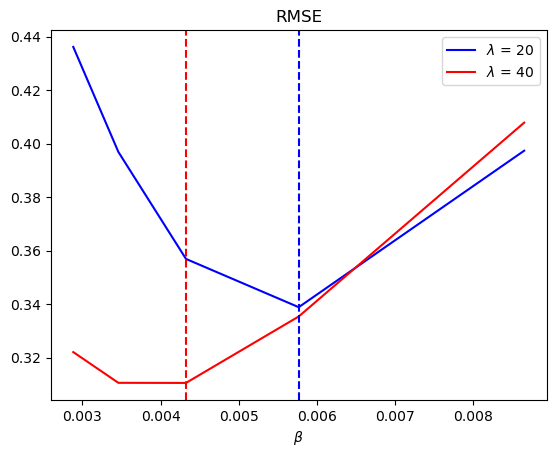

In [42]:
beta1 = hist1.loc[hist1['rmse'] == hist1['rmse'].min()]['beta'].iloc[0]
beta2 = hist2.loc[hist2['rmse'] == hist2['rmse'].min()]['beta'].iloc[0]
print('lambda = {}, best beta = {}'.format(lamb1, beta1))
print('lambda = {}, best beta = {}'.format(lamb2, beta2))

plt.plot(hist1.loc[:, 'beta'], hist1.loc[:, 'rmse'], label=r'$\lambda$ = {}'.format(lamb1), c='b')
plt.plot(hist2.loc[:, 'beta'], hist2.loc[:, 'rmse'], label=r'$\lambda$ = {}'.format(lamb2), c='r')
plt.axvline(x=beta1, ls='--', c='b')
plt.axvline(x=beta2, ls='--', c='r')
plt.xlabel(r'$\beta$')
plt.ylabel('RMSE')
plt.legend()
plt.show()
# plt.savefig('lqmDnCNNLambdaBeta.png', bbox_inches='tight')

lambda = 20, best mu = 0.3
lambda = 40, best mu = 0.4


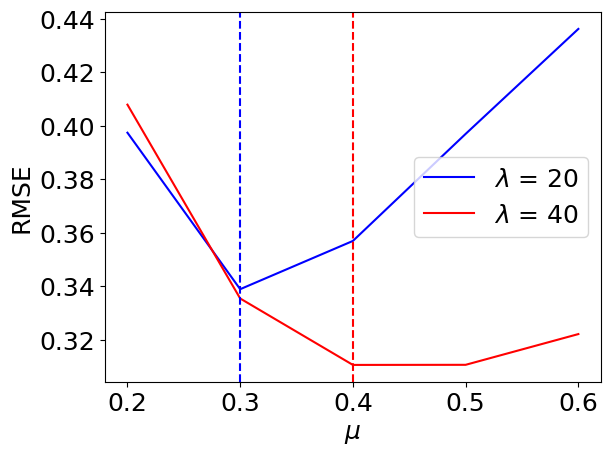

In [17]:
mu1 = hist1.loc[hist1['rmse'] == hist1['rmse'].min()]['mu'].iloc[0]
mu2 = hist2.loc[hist2['rmse'] == hist2['rmse'].min()]['mu'].iloc[0]
print('lambda = {}, best mu = {}'.format(lamb1, mu1))
print('lambda = {}, best mu = {}'.format(lamb2, mu2))

plt.plot(hist1.loc[:, 'mu'], hist1.loc[:, 'rmse'], label=r'$\lambda$ = {}'.format(lamb1), c='b')
plt.plot(hist2.loc[:, 'mu'], hist2.loc[:, 'rmse'], label=r'$\lambda$ = {}'.format(lamb2), c='r')
plt.axvline(x=mu1, ls='--', c='b')
plt.axvline(x=mu2, ls='--', c='r')
plt.xlabel(r'$\mu$')
plt.ylabel('RMSE')
plt.legend()
plt.show()
# plt.savefig('lqmDnCNNLambda.png', bbox_inches='tight')